In [1]:
import numpy as np 
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import math
from matplotlib import pyplot as plt

import sys
sys.path.append('../utils')

from text.utils import save_text_state, load_text_state, build_text_state, load_books, Vocabulary
from model.utils import get_device, load_model_state, save_model_state, build_model_state

from multitext_model import MultiTextModel, get_loss_function
import torchtext

### Verify if CUDA is available

In [2]:
device = get_device()
print(device)

cuda


### Loading word vectors and training/validation dataset

In [3]:
LOAD_CHECKPOINTS = True

CHECKPOINT_BASE = 'checkpoints'
DATASET_FILENAME = '../datasets/books.pk'
AUTHORS = ['Friedrich Nietzsche', 'Ernest Hemingway', 'Oscar Wilde']

VAL_PARTITION = 0.3 
MIN_SENTENCE_LENGTH = 5
MAX_SENTENCE_LENGTH = 20
BATCH_SIZE = 8

VECTORS_LOADED = 40000

In [4]:
vocabs = []
train_datasets = []
test_datasets = []

min_len_train = None
min_len_test = None

for author in AUTHORS:
    # Try loading dataset, if it doesn't exists then creates it
    try:
        if not LOAD_CHECKPOINTS:
            print('New training required')
            raise Error('New training required')

        vocab, train_dataset, test_dataset = load_text_state(os.path.join(CHECKPOINT_BASE, author + '_text.pk'))    
        print('Checkpoint loaded')
    except:        
        books = load_books(DATASET_FILENAME, author=author)
        vocab, train_dataset, test_dataset = build_text_state(books, MIN_SENTENCE_LENGTH, MAX_SENTENCE_LENGTH, VAL_PARTITION, vocab_name=author)  
        print('No checkpoint found. New partition.')
        print('Included books:')
        for book in books:
            print('\t', book)
            
    
    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)
    vocabs.append(vocab)

No checkpoint found. New partition.
Included books:
	 Name: The dawn of day   Author: Friedrich Nietzsche
	 Name: The antichrist   Author: Friedrich Nietzsche
	 Name: We philologists   Author: Friedrich Nietzsche
	 Name: Ecce Homo   Author: Friedrich Nietzsche
	 Name: Thoughts out of season   Author: Friedrich Nietzsche
	 Name: The joyful wisdom   Author: Friedrich Nietzsche
	 Name: The will to power   Author: Friedrich Nietzsche
	 Name: The birth of tragedy   Author: Friedrich Nietzsche
	 Name: Thus spake Zarathustra   Author: Friedrich Nietzsche
	 Name: The case of Wagner   Author: Friedrich Nietzsche
	 Name: On the future of our educational institutions   Author: Friedrich Nietzsche
No checkpoint found. New partition.
Included books:
	 Name: Winner take nothing   Author: Ernest Hemingway
	 Name: Green hills of Africa   Author: Ernest Hemingway
	 Name: Across the river and into the trees   Author: Ernest Hemingway
	 Name: The sun also rises   Author: Ernest Hemingway
	 Name: In our t

In [5]:
print(books[0].content[:100])

[['\ufeff', 'THE', 'YOUNG', 'KING', 'The', 'lad', 'for', 'he', 'was', 'only', 'a', 'lad', ',', 'being', 'but', 'sixteen', 'years', 'of', 'age', 'was', 'not', 'sorry', 'at', 'their', 'departure', ',', 'and', 'had', 'flung', 'himself', 'back', 'with', 'a', 'deep', 'sigh', 'of', 'relief', 'on', 'the', 'soft', 'cushions', 'of', 'his', 'embroidered', 'couch', ',', 'lying', 'there', ',', 'wild', 'eyed', 'and', 'open', 'mouthed', ',', 'like', 'a', 'brown', 'woodland', '<ent>', ',', 'or', 'some', 'young', 'animal', 'of', 'the', 'forest', 'newly', 'snared', 'by', 'the', 'hunters'], ['And', ',', 'indeed', ',', 'it', 'was', 'the', 'hunters', 'who', 'had', 'found', 'him', ',', 'coming', 'upon', 'him', 'almost', 'by', 'chance', 'as', ',', 'bare', 'limbed', 'and', 'pipe', 'in', 'hand', ',', 'he', 'was', 'following', 'the', 'flock', 'of', 'the', 'poor', 'goatherd', 'who', 'had', 'brought', 'him', 'up', ',', 'and', 'whose', 'son', 'he', 'had', 'always', 'fancied', 'himself', 'to', 'be'], ['The', 'chil

In [6]:
for idx, author in enumerate(AUTHORS):
    save_text_state(
        os.path.join(CHECKPOINT_BASE, author + '_text.pk'), 
        vocabs[idx], 
        train_datasets[idx], 
        test_datasets[idx]
    ) 

In [7]:
# Build full vocab
vocab = Vocabulary('Multitext')
fasttext = torchtext.vocab.FastText(language='en', max_vectors=VECTORS_LOADED - len(vocab), cache='../.vector_cache')

for word in fasttext.stoi.keys():
    vocab.add_word(word)        

In [8]:
# Map all datasets to new indices
train_dataloaders = []
test_dataloaders = []

for train_dataset, test_dataset in zip(train_datasets, test_datasets):
    train_dataset.change_vocab(vocab)
    test_dataset.change_vocab(vocab)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_dataloaders.append(train_dataloader)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloaders.append(test_dataloader)
    
    print(len(train_dataloader), len(test_dataloader))

1542 661
1814 778
847 363


### Loading components

In [9]:
VOCAB_SIZE = len(vocab)

LEARNING_RATE = 1e-4
BETA_1 = 0.9
BETA_2 = 0.999
EPOCHS = 50
NUM_HEADS = 15
ENCODER_LAYERS = 2
DECODER_LAYERS = 1
EMBEDDING_SIZE = 512
FF_DIM = 1024
DROPOUT=0.2
STEP_LR_DECAY = 15
LR_FACTOR_DECAY = 0.7

In [10]:
print(type(fasttext.vectors))

<class 'torch.Tensor'>


In [11]:
model = MultiTextModel(
    authors = AUTHORS,
    vocab_size=VOCAB_SIZE,
    embedding_size=fasttext.dim, 
    #embedding_size=EMBEDDING_SIZE, 
    num_heads=NUM_HEADS, 
    encoder_layers=ENCODER_LAYERS, 
    decoder_layers=DECODER_LAYERS, 
    dim_feedforward=FF_DIM,
    dropout=DROPOUT
)


if fasttext.vectors.size()[0] < VECTORS_LOADED:
    vectors = torch.normal(0, 0.1, size=(VECTORS_LOADED - fasttext.vectors.size()[0], fasttext.dim))
    vectors = torch.cat([vectors, fasttext.vectors], dim=0)
else:
    vectors = fasttext.vectors

model.embedding.weight.data.copy_(vectors)


optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE,
    betas=(BETA_1, BETA_2)
)
    
loss_fn = get_loss_function(len(AUTHORS))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_LR_DECAY, gamma=LR_FACTOR_DECAY)

In [12]:
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    model, optimizer, last_epoch, train_loss_history, val_loss_history, best_val_loss = load_model_state(
        os.path.join(CHECKPOINT_BASE, 'best.pt'), 
        model, 
        optimizer
    )
    
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    print('Checkpoint loaded')
    
except:
    last_epoch, train_loss_history, val_loss_history, best_val_loss, _, _, _ = build_model_state()
    print('No checkpoints found. New training.')
    pass

model = model.to(device)


No checkpoints found. New training.


### Training and validation

In [13]:
def train_step(transformer, loss_fn, optimizer, source, target):
    transformer.train()

    transformer.zero_grad()
    optimizer.zero_grad()

    decodings = transformer(source, target)
    
    loss = loss_fn(source, decodings)
    loss.backward()      
    optimizer.step()
    return loss.item()    

In [14]:
def val_step(transformer, loss_fn, source, target):
    transformer.eval()
    
    with torch.no_grad():
        decodings = transformer(source, target)
        loss = loss_fn(source, decodings)

        return loss.item(), decodings

In [15]:
def sample(iterators, dataloaders, device):
    source = []
    target = []
    for idx, it in enumerate(iterators):
        try:
            example = next(it).to(device)
        except:
            iterators[idx] = iter(dataloaders[idx])
            example = next(iterators[idx]).to(device)
            
        source.append(example[:, 1:])
        target.append(example[:, :-1])
    return source, target

In [16]:
# Define steps where examples will be sampled 
test_dls_its = [ iter(test_dataloaders[idx]) for idx, _ in enumerate(AUTHORS) ]

# For EPOCHS
for epoch in range(last_epoch + 1, EPOCHS + last_epoch):
    
    print('*************************** EPOCH {} ***************************'.format(epoch))

    # Restart train datasets
    train_dls_its = [ iter(train_dataloaders[idx]) for idx, _ in enumerate(AUTHORS) ]
    # Get max of dataloaders lengths
    total_batches_tr = max([ len(train_dataloaders[idx]) for idx, _ in enumerate(AUTHORS)  ])
    # Progress bar for training dataset
    progress_bar = tqdm(range(total_batches_tr))
    
    train_loss = 0

    # For all data in training dataset
    # Training
    for batch_idx in progress_bar:
        
        # Add train loss to progress bar
        progress_bar.set_postfix({
            'tr_loss': train_loss / (batch_idx + 1), 
            'lr': scheduler.get_lr()[0]
        })

        # Train step
        source, target = sample(train_dls_its, train_dataloaders, device)
        train_loss += train_step(model, loss_fn, optimizer, source, target)


        if batch_idx == 0:
            source, target = sample(test_dls_its, test_dataloaders, device)
            
            for idx, author in enumerate(AUTHORS):
                
                src = [source[idx]] * len(AUTHORS)
                tgt = [target[idx]] * len(AUTHORS)
                                
                with torch.no_grad():
                    _, decodings = val_step(model, loss_fn, src, tgt)
                
                # Print real sentence
                real = vocab.to_words(src[idx][0].cpu().numpy())
                print('-------------------- Author {} --------------------'.format(author))
                print('Real: {}'.format(' '.join(real)))
                
                
                # Decode and print recovered sentences
                for jdx, jauthor in enumerate(AUTHORS):
                    decoded_sent = torch.argmax(decodings[jdx][0], dim=-1).cpu().numpy()
                    
                    print('***************************************************')
                    print('Decoded {}: {}'.format(jauthor, ' '.join(vocab.to_words(decoded_sent))))

    # Validation
    val_dls_its = [ iter(test_dataloaders[idx]) for idx, _ in enumerate(AUTHORS) ]
    total_batches_val = max([ len(test_dataloaders[idx]) for idx, _ in enumerate(AUTHORS)  ])
    
    # Progress bar for training dataset
    progress_bar = tqdm(range(total_batches_val))
    val_loss = 0

    for batch_idx in progress_bar:
        progress_bar.set_postfix({
            'val_loss': val_loss / (batch_idx + 1)
        })
                
        source, target = sample(test_dls_its, test_dataloaders, device)
        with torch.no_grad():
            val_loss += val_step(model, loss_fn, source, target)[0]
    
    # Save losses in history
    train_loss_history.append(train_loss / total_batches_tr)
    val_loss_history.append(val_loss / total_batches_val)
    
    # If this model is best than other
    if best_val_loss is None or val_loss / total_batches_val < best_val_loss:
        best_val_loss = val_loss / total_batches_val
        
        save_model_state(
            os.path.join(CHECKPOINT_BASE, 'best.pt'), 
            model, 
            optimizer, 
            epoch, 
            train_loss_history, 
            val_loss_history, 
            best_val_loss
        )
        
    # Save last model
    save_model_state(
        os.path.join(CHECKPOINT_BASE, 'last.pt'), 
        model, 
        optimizer, 
        epoch, 
        train_loss_history, 
        val_loss_history, 
        best_val_loss
    )    
    
    scheduler.step()    

*************************** EPOCH 1 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: they strive after it , and have the <unk> scent for all those positions in which precisely they themselves can <eos>
***************************************************
Decoded Friedrich Nietzsche: mitre mitre amo decimated decimated grenadiers grenadiers grenadiers aren aren trimble aren exposing hull grenadiers desc grenadiers dot trimble wenceslaus wenceslaus
***************************************************
Decoded Ernest Hemingway: r_ r_ ibaraki stefani stefani stefani príncipe twisted twisted twisted twisted redeveloped cima cima deeds anselmo twisted barbara redeveloped redeveloped beggars
***************************************************
Decoded Oscar Wilde: koh addington digestion saxophones saxophones positional positional positional positional <pad> <pad> <pad> lied lied seeded brendon brendon brendon brendon xc xc
-------------------- Author Ernest Hemingway --------------------
Real: you will <u


*************************** EPOCH 2 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: let it be very justice for the world to become full of the storms of our vengeance thus do they <eos>
***************************************************
Decoded Friedrich Nietzsche: we it not be men for the man to be our of the man of our man to not to <eos>
***************************************************
Decoded Ernest Hemingway: you it have a up to the colonel to to his of the colonel of a man to you we <eos>
***************************************************
Decoded Oscar Wilde: you it have a with to the great to him with of the great of him him to you that <eos>
-------------------- Author Ernest Hemingway --------------------
Real: that was nothing , <ent> said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: that is not , <unk> i <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa


*************************** EPOCH 3 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: it is true that man can only become man by first <unk> this <unk> element in his thoughts , comparisons <eos>
***************************************************
Decoded Friedrich Nietzsche: it is true that man can only been man by first <unk> this <unk> means in his truth , regard <eos>
***************************************************
Decoded Ernest Hemingway: it is good that man can only been man by old <unk> this <unk> good in his things , drink <eos>
***************************************************
Decoded Oscar Wilde: it is nothing that man can only been man by was <unk> this <unk> quite in his things , those <eos>
-------------------- Author Ernest Hemingway --------------------
Real: if he lived in <unk> country , he could <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: if he long in <unk> life ,


*************************** EPOCH 4 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: but the counter impulses are still so powerful that one can really speak of the future of mankind with little <eos>
***************************************************
Decoded Friedrich Nietzsche: but the germans self are still so whose that one can really speak of the future of mankind with little <eos>
***************************************************
Decoded Ernest Hemingway: but the money things are still so american that one can really asked of the fish of your with little <eos>
***************************************************
Decoded Oscar Wilde: but the conditions themselves are still so whose that one can really happy of the fact of life with little <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i was studying them , too excited to be happy as i watched them , when i heard m ' <eos>
***************************************************
Decoded Friedrich Nietzsche: i was 


*************************** EPOCH 5 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: we should probably support the development and the <unk> of democratic tendencies <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: we should still deal the development and the <unk> of general philosophers <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: we should probably start the new and the <unk> of sir blood <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: we should still bear the development and the <unk> of herodotus sympathy <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: one time a fellow comes here came to me and said he wanted me to cook them a big supper <eos>
*********************


*************************** EPOCH 6 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: they justify even a certain want of education for which we must make <unk> owing to their country and the <eos>
***************************************************
Decoded Friedrich Nietzsche: they justify even a certain want of education for which we must make <unk> owing to their hand and the <eos>
***************************************************
Decoded Ernest Hemingway: they keep even a certain want of street for which we must make <unk> were to their country and the <eos>
***************************************************
Decoded Oscar Wilde: they merely even a certain want of public for which we must make <unk> due to their country and the <eos>
-------------------- Author Ernest Hemingway --------------------
Real: then he went down very slowly <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich


*************************** EPOCH 7 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: for he , in so far as he thinks he has absorbed the blessings of education , is merely the <eos>
***************************************************
Decoded Friedrich Nietzsche: for he , in so far as he thinks he has class the sacrifice of education , is merely the <eos>
***************************************************
Decoded Ernest Hemingway: for he , in so far as he knows he has steadily the secret of school , is rather the <eos>
***************************************************
Decoded Oscar Wilde: for he , in so far as he knows he has accompanied the treasure of school , is merely the <eos>
-------------------- Author Ernest Hemingway --------------------
Real: well , i said , they <unk> <unk> somewhere along here <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: well , i said , they <unk> <unk> somewhere along h


*************************** EPOCH 8 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: the <unk> of the order of rank <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: the <unk> of the order of rank <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: the <unk> of the order of army <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: the <unk> of the order of rank <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i have done things without <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
**************************************


*************************** EPOCH 9 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: <unk> in the treatment <unk> there is no attempt at <unk> weakness by means of any <unk> system <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: <unk> in the treatment <unk> there is no attempt at <unk> weakness by means of any <unk> system <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: <unk> in the action <unk> there is no given at <unk> steady by means of any <unk> ground <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: <unk> in the effect <unk> there is no attempt at <unk> strength by means of any <unk> system <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he did not change his direction and the men shouted <unk> <ent> ! <unk> ! toro ! and waved their <eos>
***************************************************
Decoded Friedrich Ni


*************************** EPOCH 10 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: knowledge , and the affirmation of reality , are just as necessary to the strong man as <unk> , the <eos>
***************************************************
Decoded Friedrich Nietzsche: knowledge , and the affirmation of reality , are just as necessary to the strong man as <unk> , the <eos>
***************************************************
Decoded Ernest Hemingway: knowledge , and the greatness of pity , are just as necessary to the strong man as <unk> , the <eos>
***************************************************
Decoded Oscar Wilde: knowledge , and the achievements of reality , are just as necessary to the strong man as <unk> , the <eos>
-------------------- Author Ernest Hemingway --------------------
Real: <ent> put the left in his face <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: <ent>


*************************** EPOCH 11 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: the latter was <unk> by nietzsche <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: the latter was <unk> by nietzsche <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: the course was <unk> by god <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: the latter was <unk> by individualism <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i came to tell you that it looks quite good for the shoot <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
*********************


*************************** EPOCH 12 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: every great crime against culture for the last four centuries lies on their conscience <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: every great crime against culture for the last four centuries lies on their conscience <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: every great shooter against part for the last four dialect lies on their conscience <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: every great crime against culture for the last four centuries lies on their conscience <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: awfully nice of you to ask me <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


*************************** EPOCH 13 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: what is our <ent> ? what do we conceive of our neighbour except his limits <unk> i mean that whereby <eos>
***************************************************
Decoded Friedrich Nietzsche: what is our <ent> ? what do we conceive of our neighbour except his limits <unk> i mean that whereby <eos>
***************************************************
Decoded Ernest Hemingway: what is our <ent> ? what do we realize of our lick except his lies <unk> i mean that various <eos>
***************************************************
Decoded Oscar Wilde: what is our <ent> ? what do we conceive of our mine except his service <unk> i mean that specially <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i ' ll remember that all week and try to be one <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: i ' let remember tha


*************************** EPOCH 14 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: in good spirits and joyful , because this day hath come to an end ! and thou <unk> <unk> dance <eos>
***************************************************
Decoded Friedrich Nietzsche: in good spirits and joyful , because this day hath come to an end ! and thou <unk> <unk> dance <eos>
***************************************************
Decoded Ernest Hemingway: in good share and splendid , because this day man come to an end ! and thou <unk> <unk> dance <eos>
***************************************************
Decoded Oscar Wilde: in good spirits and faithful , because this day hath come to an end ! and thou <unk> <unk> dance <eos>
-------------------- Author Ernest Hemingway --------------------
Real: no , they wouldn ' t <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: no , they really ' t <pa


*************************** EPOCH 15 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: originally , and above all in the time of the <unk> , israel maintained the right attitude of things , <eos>
***************************************************
Decoded Friedrich Nietzsche: originally , and above all in the time of the <unk> , israel maintained the right attitude of things , <eos>
***************************************************
Decoded Ernest Hemingway: since , and above all in the time of the <unk> , africa remained the right attitude of things , <eos>
***************************************************
Decoded Oscar Wilde: ruled , and above all in the time of the <unk> , democracy resulted the right attitude of things , <eos>
-------------------- Author Ernest Hemingway --------------------
Real: hebrew wine seller here you are , gentlemen <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Niet


*************************** EPOCH 16 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: all our present institutions belong to the second class <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: all our present institutions belong to the second class <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: all our present organization belong to the second class <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: all our present private belong to the second class <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i had one on my forehead that people still <unk> on , asking if i had <unk> my head <pad> <eos>
******************


*************************** EPOCH 17 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: it hath been enough that i have carried thee about with me ! as yet have i not been strong <eos>
***************************************************
Decoded Friedrich Nietzsche: it hath been enough that i have carried thee about with me ! as yet have i not been strong <eos>
***************************************************
Decoded Ernest Hemingway: it always been enough that i have carried thee about with me ! as yet have i not been strong <eos>
***************************************************
Decoded Oscar Wilde: it hath been enough that i have carried thee about with me ! as yet have i not been strong <eos>
-------------------- Author Ernest Hemingway --------------------
Real: for three years , or almost three years , he had never seen beyond <ent> i am sure he had <eos>
***************************************************
Decoded Friedrich Nietzsche: for three years , or almost three years , he had never


*************************** EPOCH 18 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: they are not at liberty to play second <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: they are not at liberty to play second <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: they are not at purpose to play second <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: they are not at liberty to play second <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he was <unk> , but brett couldn ' t hold him , and he got up <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Fr


*************************** EPOCH 19 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: o my soul , i have taken from thee all <unk> and knee <unk> and homage paying <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: o my soul , i have taken from thee all <unk> and knee <unk> and homage payment <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: o my soul , i have taken from thee all <unk> and knee <unk> and homage paying <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: o my soul , i have taken from thee all <unk> and knee <unk> and welcomes wasted <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: they are a damn sight more important when you put them on paper <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: they are a afraid


*************************** EPOCH 20 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: the weak and the botched shall perish <unk> first principle of our charity <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: the weak and the botched shall perish <unk> first principle of our charity <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: the dull and the busted shall confidence <unk> first principle of our spare <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: the weak and the bill shall die <unk> first principle of our charity <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: <ent> was eating fruit when we came in and <unk> a bottle of wine <pad> <pad> <pad> <pad> <pad> <pad> <eos>
**************************


*************************** EPOCH 21 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: consequently it may also be the indication of a noble mind to make <unk> of pathetic situations , and to <eos>
***************************************************
Decoded Friedrich Nietzsche: consequently it may also be the indication of a noble mind to make <unk> of pathetic situations , and to <eos>
***************************************************
Decoded Ernest Hemingway: while it may also be the unfortunate of a noble mind to make <unk> of awful net , and to <eos>
***************************************************
Decoded Oscar Wilde: consequently it may also be the possibility of a noble mind to make <unk> of pathetic unhealthy , and to <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i knew we still had a chance on the lick in the morning and i was not going to worry <eos>
***************************************************
Decoded Friedrich Nietzsche: i knew we still had a


*************************** EPOCH 22 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: the highest states of the strong become bad <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: the highest states of the strong become bad <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: the highest states of the strong become bad <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: the highest states of the strong become bad <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: then , too , danger was in the hands of pop and for pop she had a complete , clear <eos>
********************************************


*************************** EPOCH 23 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: not till then does nature attain her artistic jubilee <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: not till then does nature attain her artistic jubilee <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: not till then does nature attain her artistic peace <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: not till then does nature attain her artistic challenge <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: then , once they have <unk> themselves , they <unk> it and you get more <unk> <pad> <pad> <pad> <pad> <eos>
*********


*************************** EPOCH 24 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: o my soul , i have taken from thee all <unk> and knee <unk> and homage paying <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: o my soul , i have taken from thee all <unk> and knee <unk> and homage paying <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: o my soul , i have taken from thee all <unk> and knee <unk> and homage paying <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: o my soul , i have taken from thee all <unk> and knee <unk> and ferrara paying <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: you <unk> ' t feel that way <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: you <unk> ' t feel 


*************************** EPOCH 25 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: they have found out that interesting <unk> is possible even in their art <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: they have found out that interesting <unk> is possible even in their art <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: they have found out that interesting <unk> is possible even in their art <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: they have found out that interesting <unk> is possible even in their art <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: have i told you , yet , properly , that i love you ? you told me <pad> <pad> <pad> <eos>
************************************************


*************************** EPOCH 26 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: <ent> , on the other hand , were more familiar with the thought that <unk> also may have dignity , <eos>
***************************************************
Decoded Friedrich Nietzsche: <ent> , on the other hand , were more familiar with the thought that <unk> also may have dignity , <eos>
***************************************************
Decoded Ernest Hemingway: <ent> , on the other hand , were more existent with the thought that <unk> also may have dignity , <eos>
***************************************************
Decoded Oscar Wilde: <ent> , on the other hand , were more familiar with the thought that <unk> also may have dignity , <eos>
-------------------- Author Ernest Hemingway --------------------
Real: just a <unk> , said <ent> want to start now ? come on <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: just a <unk> , sai


*************************** EPOCH 27 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: one should note the <unk> of command , with which the german cities are absolutely surrounded at present , when <eos>
***************************************************
Decoded Friedrich Nietzsche: one should note the <unk> of command , with which the german cities are absolutely surrounded at present , when <eos>
***************************************************
Decoded Ernest Hemingway: one should note the <unk> of command , with which the german cities are absolutely surrounded at present , when <eos>
***************************************************
Decoded Oscar Wilde: one should note the <unk> of command , with which the german cities are absolutely surrounded at present , when <eos>
-------------------- Author Ernest Hemingway --------------------
Real: you don ' t need to thank him <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
*****************************************


*************************** EPOCH 28 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: and this is the title of the modern philosophers to sit among the great <unk> of life or rather of <eos>
***************************************************
Decoded Friedrich Nietzsche: and this is the title of the modern philosophers to sit among the great <unk> of life or rather of <eos>
***************************************************
Decoded Ernest Hemingway: and this is the title of the modern writers to sit among the great <unk> of life or rather of <eos>
***************************************************
Decoded Oscar Wilde: and this is the title of the modern philosophers to sit among the great <unk> of life or rather of <eos>
-------------------- Author Ernest Hemingway --------------------
Real: that is twenty years at five hundred lira a year for the <ent> d <ent> the <unk> carries ten guineas <eos>
***************************************************
Decoded Friedrich Nietzsche: that is twenty yea


*************************** EPOCH 29 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: no salvation of the soul ever results from it , but only a new kind of spiritual illness <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: no salvation of the soul ever results from it , but only a new kind of spiritual illness <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: no compass of the soul ever results from it , but only a new kind of priests critic <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: no doctrine of the soul ever results from it , but only a new kind of spiritual critic <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i wish that your mistress was here and we could have movement <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: i w


*************************** EPOCH 30 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: right on the path which he was about to descend came two kings walking , <unk> with <unk> and <unk> <eos>
***************************************************
Decoded Friedrich Nietzsche: right on the path which he was about to descend came two kings walking , <unk> with <unk> and <unk> <eos>
***************************************************
Decoded Ernest Hemingway: right on the path which he was about to settle came two kings walking , <unk> with <unk> and <unk> <eos>
***************************************************
Decoded Oscar Wilde: right on the path which he was about to wander came two kings walking , <unk> with <unk> and <unk> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: they were going with the wind now and they were both tired <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: they 


*************************** EPOCH 31 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: therefore do i wash the hand that hath helped the <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: therefore do i wash the hand that hath helped the <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: any do i wash the hand that doubt helped the <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: therefore do i shoes the hand that hath helped the <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: they ' re so bloody , <ent> said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
**************************************************


*************************** EPOCH 32 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: until now no single individuality , or only the very rarest , have been free <unk> they were influenced by <eos>
***************************************************
Decoded Friedrich Nietzsche: until now no single individuality , or only the very rarest , have been free <unk> they were influenced by <eos>
***************************************************
Decoded Ernest Hemingway: until now no single righteous , or only the very lesser , have been free <unk> they were paintings by <eos>
***************************************************
Decoded Oscar Wilde: until now no single spontaneous , or only the very rarest , have been free <unk> they were influenced by <eos>
-------------------- Author Ernest Hemingway --------------------
Real: and a chauffeur in <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Dec


*************************** EPOCH 33 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: and we should not seek to attain them by the aid of the highest means and instruments which exist means <eos>
***************************************************
Decoded Friedrich Nietzsche: and we should not seek to attain them by the aid of the highest means and instruments which exist means <eos>
***************************************************
Decoded Ernest Hemingway: and we should not seek to attain them by the aid of the highest means and instruments which standard means <eos>
***************************************************
Decoded Oscar Wilde: and we should not seek to attain them by the aid of the highest means and instruments which exist means <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i ' m going to have a drink <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Ni


*************************** EPOCH 34 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: o heaven above me ! thou pure , thou lofty heaven ! this is now thy purity unto me , <eos>
***************************************************
Decoded Friedrich Nietzsche: o heaven above me ! thou pure , thou lofty heaven ! this is now thy purity unto me , <eos>
***************************************************
Decoded Ernest Hemingway: o heaven above me ! thou pure , thou appreciated heaven ! this is now thy purity to me , <eos>
***************************************************
Decoded Oscar Wilde: o heaven above me ! thou pure , thou lofty heaven ! this is now thy purity unto me , <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he tried a pass with the <unk> and the bull did not move <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: he tried a pass with the <unk> and the bull did not move <pad> <pad


*************************** EPOCH 35 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: always appearing <unk> when , in the greece of the third century , philosophy had become a matter of public <eos>
***************************************************
Decoded Friedrich Nietzsche: always runaway <unk> when , in the greece of the third century , philosophy had become a matter of public <eos>
***************************************************
Decoded Ernest Hemingway: always sung <unk> when , in the greece of the third city , someone had become a matter of public <eos>
***************************************************
Decoded Oscar Wilde: always lastly <unk> when , in the greece of the third century , philosophy had become a matter of public <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he was standing up and looking at them <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Frie


*************************** EPOCH 36 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: he suddenly saw , with horror struck , wide open eyes , the non german <unk> , hiding itself in <eos>
***************************************************
Decoded Friedrich Nietzsche: he suddenly saw , with horror struck , wide open eyes , the non german <unk> , hiding itself in <eos>
***************************************************
Decoded Ernest Hemingway: he suddenly saw , with horror struck , wide open eyes , the non german <unk> , hiding itself in <eos>
***************************************************
Decoded Oscar Wilde: he suddenly saw , with horror struck , wide open eyes , the non german <unk> , pouring itself in <eos>
-------------------- Author Ernest Hemingway --------------------
Real: they can ' t insult <ent> i won ' t stand it <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: they can ' t insult <ent> i won 


*************************** EPOCH 37 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: a new <unk> of the sense of power <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: a new <unk> of the sense of power <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: a new <unk> of the sense of power <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: a new <unk> of the sense of power <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: maybe he ' ll get enough of it , <ent> said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich


*************************** EPOCH 38 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: oh , for the man who could give us the history of that subtle feeling called loneliness ! night and <eos>
***************************************************
Decoded Friedrich Nietzsche: oh , for the man who could give us the history of that subtle feeling called loneliness ! night and <eos>
***************************************************
Decoded Ernest Hemingway: oh , for the man who could give us the history of that interesting feeling called memories ! night and <eos>
***************************************************
Decoded Oscar Wilde: oh , for the man who could give us the history of that subtle feeling called loneliness ! night and <eos>
-------------------- Author Ernest Hemingway --------------------
Real: we sat in the <unk> for a while and had coffee and then took a little walk out to the <eos>
***************************************************
Decoded Friedrich Nietzsche: we sat in the <unk> f


*************************** EPOCH 39 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: nothing seemed impossible to its powers <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: nothing seemed impossible to its powers <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: nothing seemed impossible to its attention <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: nothing seemed impossible to its power <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: <ent> was reading the paper again <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


*************************** EPOCH 40 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: it was modesty which invented in greece the word philosopher , and left to the play actors of the spirit <eos>
***************************************************
Decoded Friedrich Nietzsche: it was modesty which invented in greece the word philosopher , and left to the play actors of the spirit <eos>
***************************************************
Decoded Ernest Hemingway: it was patriotism which invented in greece the word philosopher , and left to the play voices of the spirit <eos>
***************************************************
Decoded Oscar Wilde: it was affection which invented in greece the word philosopher , and left to the play actors of the spirit <eos>
-------------------- Author Ernest Hemingway --------------------
Real: this increased <ent> ' s <unk> for boxing , but it gave him a certain <unk> of some strange sort <eos>
***************************************************
Decoded Friedrich


*************************** EPOCH 41 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: and yet it is plain to be seen that , in former times , hazard was the greatest of all <eos>
***************************************************
Decoded Friedrich Nietzsche: and yet it is plain to be seen that , in former times , hazard was the greatest of all <eos>
***************************************************
Decoded Ernest Hemingway: and yet it is plain to be seen that , in first times , hazard was the greatest of all <eos>
***************************************************
Decoded Oscar Wilde: and yet it is plain to be seen that , in former times , burying was the greatest of all <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it isn ' t far from london <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: it isn ' t far from rising <pad> <pad> <pad> <pad> <pad> 


*************************** EPOCH 42 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: we , the generous and rich in spirit , who stand at the sides of the streets like open fountains <eos>
***************************************************
Decoded Friedrich Nietzsche: we , the generous and rich in spirit , who stand at the sides of the streets like open fountains <eos>
***************************************************
Decoded Ernest Hemingway: we , the fortune and rich in spirit , who stand at the sides of the streets like open noises <eos>
***************************************************
Decoded Oscar Wilde: we , the generous and rich in spirit , who stand at the sides of the streets like open fountains <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it looks lovely , the girl said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: it looks lovely 


*************************** EPOCH 43 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: footnote <unk> <unk> this number and those which follow refer to thoughts out of season , part y in this <eos>
***************************************************
Decoded Friedrich Nietzsche: footnote <unk> <unk> this number and those which follow refer to thoughts out of season , part y in this <eos>
***************************************************
Decoded Ernest Hemingway: footnote <unk> <unk> this number and those which follow refer to thoughts out of season , part y in this <eos>
***************************************************
Decoded Oscar Wilde: somewhere <unk> <unk> this number and those which follow capital to thoughts out of season , part y in this <eos>
-------------------- Author Ernest Hemingway --------------------
Real: both men ate with their gloves on <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Deco


*************************** EPOCH 44 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: now there are so many things to which men have become so accustomed that they look upon them as quite <eos>
***************************************************
Decoded Friedrich Nietzsche: now there are so many things to which men have become so accustomed that they look upon them as quite <eos>
***************************************************
Decoded Ernest Hemingway: now there are so many things to which men have become so alike that they look upon them as quite <eos>
***************************************************
Decoded Oscar Wilde: now there are so many things to which men have become so accustomed that they look upon them as quite <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it was lonely and rainy there , and there was a battalion of <unk> <unk> in the town <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: it was lon


*************************** EPOCH 45 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: but further , are we perhaps to reckon to the honour of germans , the old <unk> top , <unk> <eos>
***************************************************
Decoded Friedrich Nietzsche: but further , are we perhaps to reckon to the honour of germans , the old <unk> top , <unk> <eos>
***************************************************
Decoded Ernest Hemingway: but further , are we perhaps to swear to the honour of germans , the old <unk> top , <unk> <eos>
***************************************************
Decoded Oscar Wilde: but further , are we perhaps to deduce to the honour of actual , the old <unk> top , <unk> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: we drove to the scene of the <unk> in trucks along <unk> shaded roads , bordered with ditches containing much <eos>
***************************************************
Decoded Friedrich Nietzsche: we drove to the scene of the <unk>


*************************** EPOCH 46 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: it actually seems , to use one of <unk> ' s own phrases , as if all things came to <eos>
***************************************************
Decoded Friedrich Nietzsche: it actually seems , to use one of <unk> ' s own phrases , as if all things came to <eos>
***************************************************
Decoded Ernest Hemingway: it actually seems , to use one of <unk> ' s own expressions , as if all things came to <eos>
***************************************************
Decoded Oscar Wilde: it actually seems , to use one of <unk> ' s own glance , as if all things came to <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it was the yellow gulf weed that had made so much <unk> in the night <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: it was the yellow gulf divers that had made so much <unk> in the night <pad>


*************************** EPOCH 47 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: and all this was believed in as morality ! <ent> ! have you understood me ? <ent> versus christ <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: and all this was believed in as morality ! <ent> ! have you understood me ? <ent> versus christ <pad> <eos>
***************************************************
Decoded Ernest Hemingway: and all this was believed in as question ! <ent> ! have you understood me ? <ent> mixed christ <pad> <eos>
***************************************************
Decoded Oscar Wilde: and all this was believed in as morality ! <ent> ! have you understood me ? <ent> against christ <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the road curved and climbed again , and ahead there were some <unk> <unk> in the road <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche


*************************** EPOCH 48 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: christianity finds sickness necessary , just as the greek spirit had need of a <unk> of health the actual <unk> <eos>
***************************************************
Decoded Friedrich Nietzsche: christianity finds sickness necessary , just as the greek spirit had need of a <unk> of health the actual <unk> <eos>
***************************************************
Decoded Ernest Hemingway: outside tells sickness necessary , just as the greek spirit had need of a <unk> of health the actual <unk> <eos>
***************************************************
Decoded Oscar Wilde: outside finds hearing necessary , just as the greek spirit had need of a <unk> of health the actual <unk> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: that ' s just it , said <ent> i ' m afraid they expected to meet me at san sebastian <eos>
***************************************************
Decoded Friedrich


*************************** EPOCH 49 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: this piety towards that which already exists in us is perhaps related to the moral element in science <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: this piety towards that which already exists in us is perhaps related to the moral element in science <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: this anecdotes towards that which already exists in us is perhaps related to the necessity effect in science <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: this virtues towards that which already means in us is perhaps within to the moral element in science <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it had gone on and changed , <unk> here , losing its lines , <unk> a little there , but <eos>
****************************************

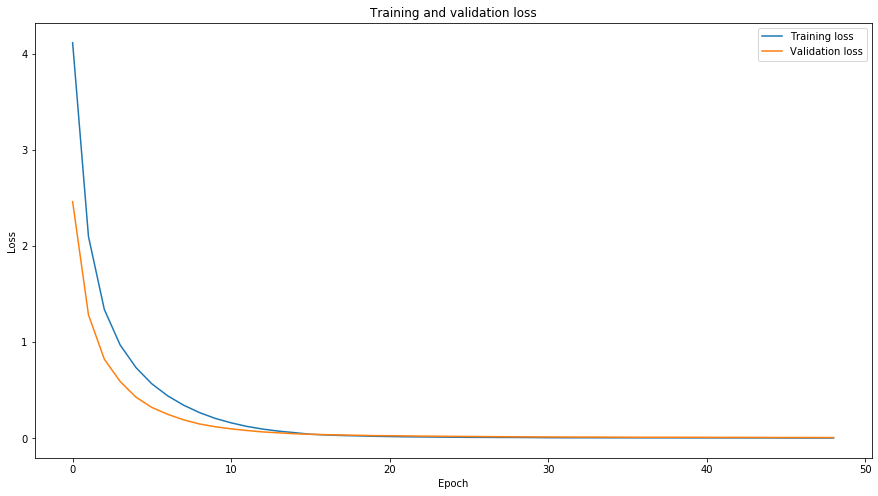

In [17]:
x = [epoch for epoch in range(len(train_loss_history))]
plt.figure(figsize=(15, 8))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.plot(x, train_loss_history, label='Training loss')
plt.plot(x, val_loss_history, label='Validation loss')

plt.legend()

plt.show()

In [18]:
argmin_val = np.argmin(val_loss_history)
print('Least validation loss: {} in epoch {}'.format(val_loss_history[argmin_val], argmin_val + 1))

Least validation loss: 0.007192154897278586 in epoch 49
